# 利用shap解释Xgboost模型

在SHAP被广泛使用之前，我们通常用feature importance或者partial dependence plot来解释xgboost。 feature importance是用来衡量数据集中每个特征的重要性。  
简单来说，每个特征对于提升整个模型的预测能力的贡献程度就是特征的重要性。  
Feature importance可以直观地反映出特征的重要性，看出哪些特征对最终的模型影响较大。但是无法判断特征与最终预测结果的关系是如何的。  
下面这个例子中，我们用鸢尾花数据集和2018年足球球员身价数据来具体阐述。  

## 0、shap解释鸢尾花xgboost模型（作业）

### 导包

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
import numpy as np
import sklearn
import time
import xgboost as xgb

### 导入数据集+数据预处理

目标变量class是鸢尾花的种类

In [2]:
iris = pd.read_csv("database/iris.csv")
iris.loc[(iris['class']=='Iris-setosa'),'class'] = 0
iris.loc[(iris['class']=='Iris-versicolor'),'class'] = 1
iris.loc[(iris['class']=='Iris-virginica'),'class'] = 2
iris = iris.sample(frac=1)
iris

,sepal length,sepal width,petal length,petal width,class
27,5.2,3.5,1.5,0.2,0
59,5.2,2.7,3.9,1.4,1
8,4.4,2.9,1.4,0.2,0
125,7.2,3.2,6.0,1.8,2
109,7.2,3.6,6.1,2.5,2
...,...,...,...,...,...
98,5.1,2.5,3.0,1.1,1
135,7.7,3.0,6.1,2.3,2
2,4.7,3.2,1.3,0.2,0
118,7.7,2.6,6.9,2.3,2


In [3]:
cols = ['sepal length', 'sepal width', 'petal length', 'petal width']
iris_feature = iris[cols]
iris_target = iris['class'].values
iris_target=iris_target.astype('int')

In [4]:
iris_feature

,sepal length,sepal width,petal length,petal width
27,5.2,3.5,1.5,0.2
59,5.2,2.7,3.9,1.4
8,4.4,2.9,1.4,0.2
125,7.2,3.2,6.0,1.8
109,7.2,3.6,6.1,2.5
...,...,...,...,...
98,5.1,2.5,3.0,1.1
135,7.7,3.0,6.1,2.3
2,4.7,3.2,1.3,0.2
118,7.7,2.6,6.9,2.3


In [5]:
iris_target

array([0, 1, 0, 2, 2, 1, 0, 0, 2, 1, 0, 0, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0,
       0, 1, 0, 1, 0, 2, 1, 2, 0, 2, 1, 1, 2, 2, 0, 0, 1, 2, 2, 2, 1, 1,
       2, 2, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 2, 1, 1, 2, 0, 1, 2, 2,
       2, 2, 2, 1, 2, 0, 0, 1, 0, 0, 0, 2, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0,
       2, 2, 1, 0, 1, 2, 2, 2, 1, 0, 2, 0, 1, 1, 0, 1, 0, 0, 1, 2, 1, 0,
       1, 2, 1, 2, 2, 0, 2, 0, 0, 2, 0, 2, 1, 0, 1, 1, 1, 0, 1, 2, 0, 1,
       2, 1, 2, 2, 0, 2, 2, 2, 0, 1, 0, 1, 1, 1, 2, 0, 2, 1])

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(iris_feature, iris_target, test_size=0.2, random_state=0)

### 初始化模型

In [7]:
iris_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=150)
iris_model.fit(iris[cols], iris['class'].values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
shap.initjs()
explainer = shap.TreeExplainer(iris_model)

获取训练集iris各个样本各个特征的SHAP值。
因为iris中有150个样本以及4个特征，我们得到的shap_values的维度是150×4。

In [9]:
shap_values = explainer.shap_values(iris[cols])
shap_values.shape

(150, 4)

获得该模型的基线ybase。

In [10]:
y_base = explainer.expected_value
print(y_base)

iris['pred'] = iris_model.predict(iris[cols])
print(iris['pred'].mean())

0.9991995
0.99919933


### 单个样本的shap值

我们可以随机检查其中一位球员身价的预测值以及其特征对预测值的影响。  
下面的数据框中第一列是特征名称，第二列是特征的数值，第三列是各个特征在该样本中对应的SHAP值  

In [11]:
j = 100
player_explainer = pd.DataFrame()
player_explainer['feature'] = cols
player_explainer['feature_value'] = iris[cols].iloc[j].values
player_explainer['shap_value'] = shap_values[j]
player_explainer

,feature,feature_value,shap_value
0,sepal length,5.4,-0.012411
1,sepal width,3.0,-0.001061
2,petal length,4.5,0.164701
3,petal width,1.5,-0.150658


我们知道一个样本中各特征SHAP值的和加上基线值应该等于该样本的预测值。  
我们可以做如下的验证

In [12]:
print('y_base + sum_of_shap_values: %.2f'%(y_base + player_explainer['shap_value'].sum()))
print('y_pred: %.2f'%(iris['pred'].iloc[j]))

y_base + sum_of_shap_values: 1.00
y_pred: 1.00


shap还提供极其强大的数据可视化功能。下图是对上面数据框的可视化。

In [13]:
shap.force_plot(explainer.expected_value, shap_values[j], iris[cols].iloc[j])

### 对特征的总体分析

除了能对单个样本的SHAP值进行可视化之外，还能对特征进行整体的可视化。
下图中每一行代表一个特征，横坐标为SHAP值。一个点代表一个样本，颜色越红说明特征本身数值越大，颜色越蓝说明特征本身数值越小。

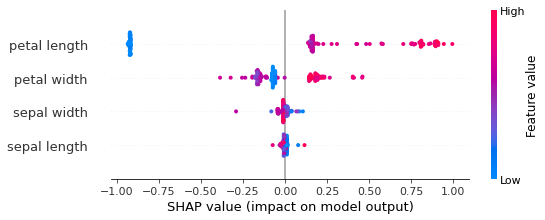

In [14]:
shap.summary_plot(shap_values, iris[cols])

我们也可以把一个特征对目标变量影响程度的绝对值的均值作为这个特征的重要性。

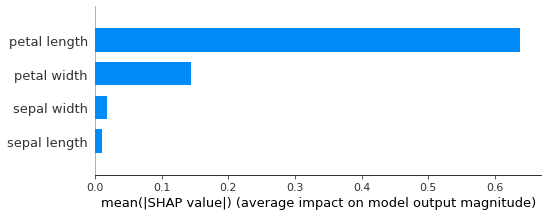

In [15]:
shap.summary_plot(shap_values, iris[cols], plot_type="bar")

### 部份依赖图Partial Dependence Plot

SHAP也提供了部分依赖图的功能，与传统的部分依赖图不同的是，这里纵坐标不是目标变量y的数值而是SHAP值。  

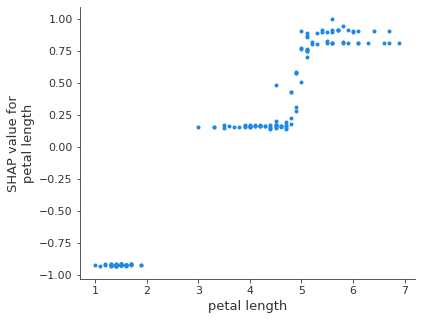

In [16]:
shap.dependence_plot('petal length', shap_values, iris[cols], interaction_index=None, show=False)

### 对多个变量的交互进行分析对多个变量的交互进行分析

我们也可以多个变量的交互作用进行分析。一种方式是采用summary_plot描绘出散点图，如下：

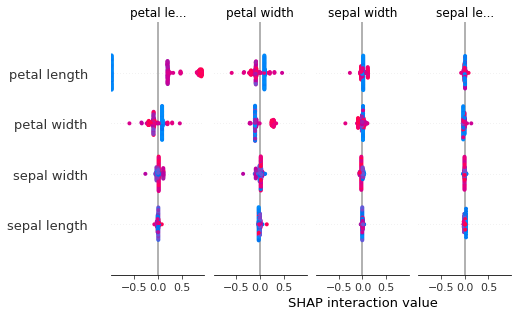

In [17]:
shap_interaction_values = shap.TreeExplainer(iris_model).shap_interaction_values(iris[cols])
shap.summary_plot(shap_interaction_values, iris[cols], max_display=4)

我们也可以用dependence_plot描绘两个变量交互下变量对目标值的影响。

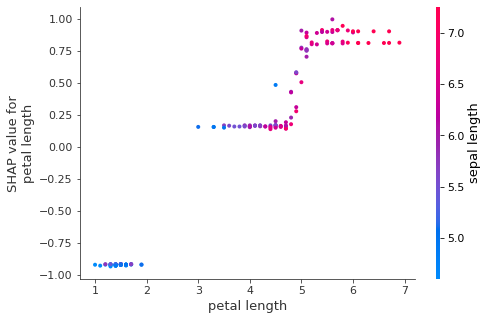

In [18]:
shap.dependence_plot('petal length', shap_values, iris[cols], interaction_index='sepal length', show=False)

## 1、Feature Importance

### 导包

In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

### 读取数据  

目标变量y是球员的身价

In [20]:
data = pd.read_csv("database/data/train.csv")
data

,id,club,league,birth_date,height_cm,weight_kg,nationality,potential,pac,sho,...,st,lw,cf,cam,cm,cdm,cb,lb,gk,y
0,0,293,25,10/4/96,177,72,78,73,65,60,...,63.0,64.0,64.0,64.0,63.0,57.0,53.0,56.0,NaN,70.0
1,1,258,24,9/21/84,178,70,51,62,56,39,...,52.0,60.0,57.0,59.0,61.0,64.0,61.0,64.0,NaN,24.0
2,2,112,3,6/8/99,177,69,52,68,68,57,...,56.0,54.0,55.0,53.0,45.0,34.0,31.0,36.0,NaN,17.0
3,3,604,9,7/25/88,181,81,54,81,76,74,...,77.0,76.0,77.0,77.0,79.0,78.0,77.0,78.0,NaN,1750.0
4,4,80,37,8/4/80,179,75,96,72,40,62,...,62.0,66.0,65.0,68.0,71.0,70.0,66.0,64.0,NaN,97.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10436,10436,277,9,5/24/98,176,79,1,75,74,43,...,52.0,54.0,53.0,52.0,52.0,58.0,60.0,62.0,NaN,55.0
10437,10437,101,8,7/27/91,178,68,147,62,66,38,...,50.0,54.0,52.0,54.0,56.0,60.0,60.0,60.0,NaN,25.0
10438,10438,626,26,2/29/92,178,72,64,77,81,77,...,76.0,72.0,73.0,70.0,62.0,46.0,41.0,46.0,NaN,1000.0
10439,10439,147,9,11/25/89,186,79,1,76,70,74,...,74.0,69.0,72.0,69.0,64.0,52.0,49.0,50.0,NaN,800.0


### 计算当时球员的年龄

将生日转换为标准日期

In [21]:
today = pd.to_datetime('2018-01-01')
data['birth_date'] = pd.to_datetime(data['birth_date'])
data

,id,club,league,birth_date,height_cm,weight_kg,nationality,potential,pac,sho,...,st,lw,cf,cam,cm,cdm,cb,lb,gk,y
0,0,293,25,1996-10-04,177,72,78,73,65,60,...,63.0,64.0,64.0,64.0,63.0,57.0,53.0,56.0,NaN,70.0
1,1,258,24,1984-09-21,178,70,51,62,56,39,...,52.0,60.0,57.0,59.0,61.0,64.0,61.0,64.0,NaN,24.0
2,2,112,3,1999-06-08,177,69,52,68,68,57,...,56.0,54.0,55.0,53.0,45.0,34.0,31.0,36.0,NaN,17.0
3,3,604,9,1988-07-25,181,81,54,81,76,74,...,77.0,76.0,77.0,77.0,79.0,78.0,77.0,78.0,NaN,1750.0
4,4,80,37,1980-08-04,179,75,96,72,40,62,...,62.0,66.0,65.0,68.0,71.0,70.0,66.0,64.0,NaN,97.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10436,10436,277,9,1998-05-24,176,79,1,75,74,43,...,52.0,54.0,53.0,52.0,52.0,58.0,60.0,62.0,NaN,55.0
10437,10437,101,8,1991-07-27,178,68,147,62,66,38,...,50.0,54.0,52.0,54.0,56.0,60.0,60.0,60.0,NaN,25.0
10438,10438,626,26,1992-02-29,178,72,64,77,81,77,...,76.0,72.0,73.0,70.0,62.0,46.0,41.0,46.0,NaN,1000.0
10439,10439,147,9,1989-11-25,186,79,1,76,70,74,...,74.0,69.0,72.0,69.0,64.0,52.0,49.0,50.0,NaN,800.0


计算当时球员的年龄

In [22]:
data['age'] = np.round((today - data['birth_date']).apply(lambda x: x.days) / 365.,1)
data

,id,club,league,birth_date,height_cm,weight_kg,nationality,potential,pac,sho,...,lw,cf,cam,cm,cdm,cb,lb,gk,y,age
0,0,293,25,1996-10-04,177,72,78,73,65,60,...,64.0,64.0,64.0,63.0,57.0,53.0,56.0,NaN,70.0,21.3
1,1,258,24,1984-09-21,178,70,51,62,56,39,...,60.0,57.0,59.0,61.0,64.0,61.0,64.0,NaN,24.0,33.3
2,2,112,3,1999-06-08,177,69,52,68,68,57,...,54.0,55.0,53.0,45.0,34.0,31.0,36.0,NaN,17.0,18.6
3,3,604,9,1988-07-25,181,81,54,81,76,74,...,76.0,77.0,77.0,79.0,78.0,77.0,78.0,NaN,1750.0,29.5
4,4,80,37,1980-08-04,179,75,96,72,40,62,...,66.0,65.0,68.0,71.0,70.0,66.0,64.0,NaN,97.5,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10436,10436,277,9,1998-05-24,176,79,1,75,74,43,...,54.0,53.0,52.0,52.0,58.0,60.0,62.0,NaN,55.0,19.6
10437,10437,101,8,1991-07-27,178,68,147,62,66,38,...,54.0,52.0,54.0,56.0,60.0,60.0,60.0,NaN,25.0,26.5
10438,10438,626,26,1992-02-29,178,72,64,77,81,77,...,72.0,73.0,70.0,62.0,46.0,41.0,46.0,NaN,1000.0,25.9
10439,10439,147,9,1989-11-25,186,79,1,76,70,74,...,69.0,72.0,69.0,64.0,52.0,49.0,50.0,NaN,800.0,28.1


### 选择特征

In [23]:
cols = ['height_cm', 'potential', 'pac', 'sho', 'pas', 'dri', 'def', 'phy', 'international_reputation', 'age']

### 训练Xgboost回归模型

In [24]:
model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=150)
model.fit(data[cols], data['y'].values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 获取features_importance

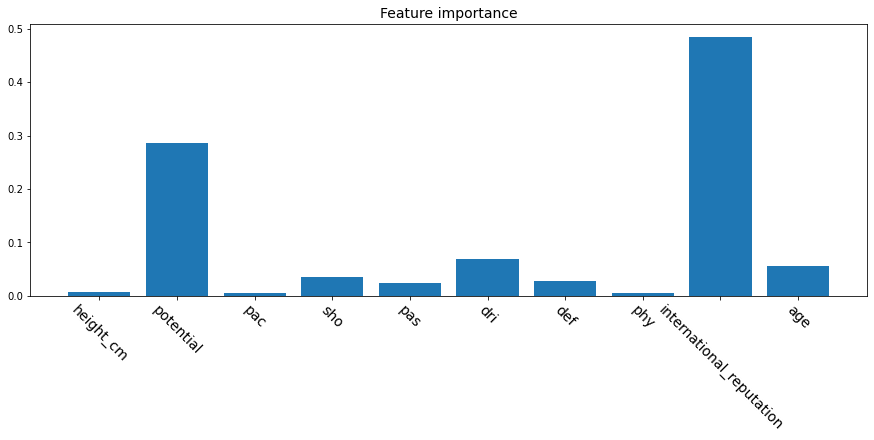

In [25]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(cols)), model.feature_importances_)
plt.xticks(range(len(cols)), cols, rotation=-45, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.show()

上图中，我们可以看出国际知名度、潜力和年龄是影响球员身价最重要的三个因素。但是这些因素和身价是正相关、负相关还是其他更复杂的相关性，我们无法从上图得知。我们也无法解读每个特征对每个个体的预测值的影响。

## 2、Shap

SHAP的名称来源于SHapley Additive exPlanation。  
Shapley value起源于合作博弈论。比如说甲乙丙丁四个工人一起打工，甲和乙完成了价值100元的工件，甲、乙、丙完成了价值120元的工件，乙、丙、丁完成了价值150元的工件，甲、丁完成了价值90元的工件，那么该如何公平、合理地分配这四个人的工钱呢？Shapley提出了一个合理的计算方法，我们称每个参与者分配到的数额为Shapley value。  
SHAP是由Shapley value启发的可加性解释模型。对于每个预测样本，模型都产生一个预测值，SHAP value就是该样本中每个特征所分配到的数值。 假设第i个样本为xi，第i个样本的第j个特征为xi,j，模型对第i个样本的预测值为yi，整个模型的基线（通常是所有样本的目标变量的均值）为ybase，那么SHAP value服从以下等式。  
yi=ybase+f(xi,1)+f(xi,2)+⋯+f(xi,k)  
其中f(xi,1)为xi,j的SHAP值。直观上看，f(xi,1)就是第i个样本中第1个特征对最终预测值yi的贡献值，当f(xi,1)>0，说明该特征提升了预测值，也正向作用；反之，说明该特征使得预测值降低，有反作用。  
很明显可以看出，与上一节中feature importance相比，SHAP value最大的优势是SHAP能对于反映出每一个样本中的特征的影响力，而且还表现出影响的正负性。  

### 导包并初始化对象

In [26]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)

获取训练集data各个样本各个特征的SHAP值。  
因为data中有10441个样本以及10个特征，我们得到的shap_values的维度是10441×10。

In [27]:
shap_values = explainer.shap_values(data[cols])
shap_values.shape

(10441, 10)

我们也可以获得该模型的基线ybase。  
通过对比发现，我们可以确认基线值就是训练集的目标变量的拟合值的均值。在这里例子中，目标变量是球员的身价（万欧元），也就是球员的平均身价为229万欧元

In [28]:
y_base = explainer.expected_value
print(y_base)

data['pred'] = model.predict(data[cols])
print(data['pred'].mean())

229.16821
229.16826


### 单个样本的shap值

我们可以随机检查其中一位球员身价的预测值以及其特征对预测值的影响。  
下面的数据框中第一列是特征名称，第二列是特征的数值，第三列是各个特征在该样本中对应的SHAP值。

In [29]:
# 比如我们挑选数据集中的第30位
j = 30
player_explainer = pd.DataFrame()
player_explainer['feature'] = cols
player_explainer['feature_value'] = data[cols].iloc[j].values
player_explainer['shap_value'] = shap_values[j]
player_explainer

,feature,feature_value,shap_value
0,height_cm,185.0,0.624574
1,potential,86.0,1092.649780
2,pac,69.0,-2.964230
3,sho,55.0,-27.901403
4,pas,68.0,-18.346529
5,dri,71.0,1.230150
6,def,76.0,110.840073
7,phy,84.0,31.128124
8,international_reputation,2.0,97.137131
9,age,20.7,-180.918213


我们知道一个样本中各特征SHAP值的和加上基线值应该等于该样本的预测值。  
我们可以做如下的验证。

In [30]:
print('y_base + sum_of_shap_values: %.2f'%(y_base + player_explainer['shap_value'].sum()))
print('y_pred: %.2f'%(data['pred'].iloc[j]))

y_base + sum_of_shap_values: 1332.65
y_pred: 1332.65


shap还提供极其强大的数据可视化功能。下图是对上面数据框的可视化。  
蓝色表示该特征的贡献是负数，红色则表示该特征的贡献是正数。最长的红色条是潜力值，球员的潜力值很高，而他的身价也因此增加了1092万；最长的蓝色条是年龄，这个球员年龄较小才20岁出头，尚未到职业巅峰，未来也有诸多不确定性，身价也因此降低了180万元。  

In [31]:
shap.force_plot(explainer.expected_value, shap_values[j], data[cols].iloc[j])

### 对特征的总体分析

除了能对单个样本的SHAP值进行可视化之外，还能对特征进行整体的可视化。  
下图中每一行代表一个特征，横坐标为SHAP值。一个点代表一个样本，颜色越红说明特征本身数值越大，颜色越蓝说明特征本身数值越小。  
我们可以直观地看出潜力potential是一个很重要的特征，而且基本上是与身价成正相关的。年龄age也会明显影响身价，蓝色点主要集中在SHAP小于0的区域，可见年纪小会降低身价估值，另一方面如果年纪很大，也会降低估值，甚至降低得更明显，因为age这一行最左端的点基本上都是红色的。  

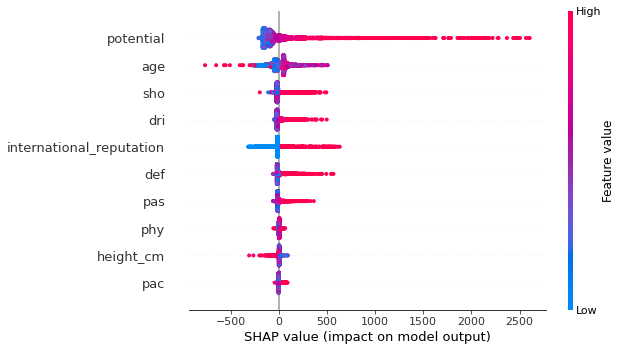

In [32]:
shap.summary_plot(shap_values, data[cols])

我们也可以把一个特征对目标变量影响程度的绝对值的均值作为这个特征的重要性。  
因为SHAP和feature_importance的计算方法不同，所以我们这里也得到了与先前不同的重要性排序。

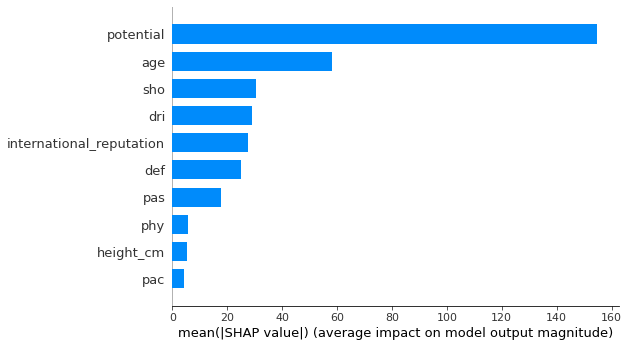

In [33]:
shap.summary_plot(shap_values, data[cols], plot_type="bar")

### 部份依赖图Partial Dependence Plot

SHAP也提供了部分依赖图的功能，与传统的部分依赖图不同的是，这里纵坐标不是目标变量y的数值而是SHAP值。  
比如下图中，年纪大概呈现出金字塔分布，也就是24到31岁这个年纪对球员的身价是拉抬作用，小于24以及大于31岁的球员身价则会被年纪所累

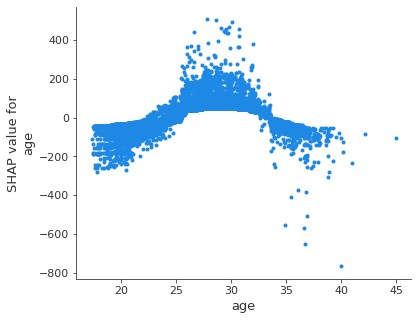

In [34]:
shap.dependence_plot('age', shap_values, data[cols], interaction_index=None, show=False)

### 对多个变量的交互进行分析

我们也可以多个变量的交互作用进行分析。一种方式是采用summary_plot描绘出散点图，如下：  

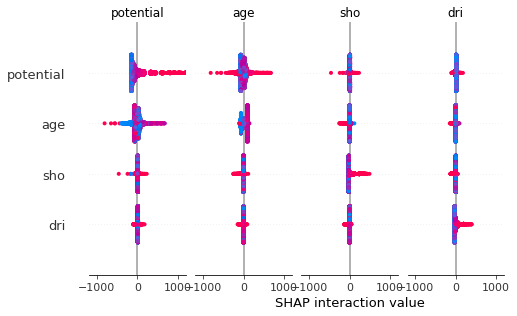

In [35]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(data[cols])
shap.summary_plot(shap_interaction_values, data[cols], max_display=4)

我们也可以用dependence_plot描绘两个变量交互下变量对目标值的影响。

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


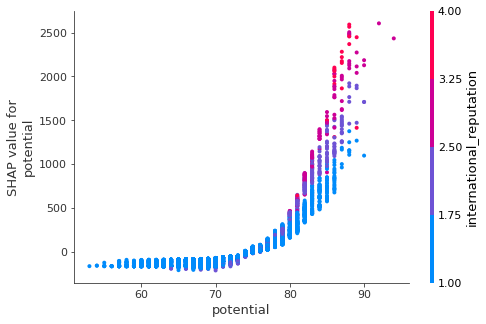

In [36]:
shap.dependence_plot('potential', shap_values, data[cols], interaction_index='international_reputation', show=False)

### 参考文献

shap：https://github.com/slundberg/shap  
利用SHAP解释Xgboost模型：http://sofasofa.io/tutorials/shap_xgboost/  
足球运动员身价估计数据集：http://sofasofa.io/competition.php?id=7